# Lab 3
## Task 1: Apply Homography (20 pts)

For given images and a homography `H`, we will apply the homography to an `poster_img` into `train_img`.

In [1]:
from IPython.display import Image
import numpy as np
import cv2

train_img = cv2.imread("images/green.png")
poster_img = cv2.imread("images/poster.png")

H = np.array([
        [ 0.8346, -0.0058, -141.3292],
        [ 0.0116,  0.8025,  -78.2148],
        [-0.0002, -0.0006,    1.    ]] )

Helper function to calculate new coordinates from given homography and other to check if int or float is in given range:

In [2]:
def calculate_coords(y, x, H):
    old_coordinates = [
        [y],
        [x],
        [1]
    ]
    
    [newY, newX, newW] = np.dot(H, old_coordinates)
    return (newY / newW, newX / newW)

def __between(v, min_v, max_v):
    return v>=min_v and v<max_v

Now we will iterate over the output image, and take `poster_img` when possible, and `train_img` when the coordinates are outside `poster_img`.

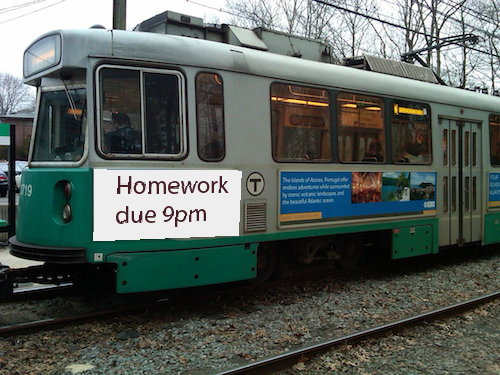

In [3]:
def apply_homography_nn(train_img, poster_img, H):
    output_img = train_img.copy()

    (height, width, channels) = output_img.shape
    (poster_h, poster_w, poster_c) = poster_img.shape

    for y in range(0, height):
        for x in range(0, width):
            (y_pos, x_pos) = calculate_coords(y, x, H)
            y_pos = int(y_pos)
            x_pos = int(x_pos)

            if __between(y_pos, 0, poster_h) and __between(x_pos, 0, poster_w):
                output_img[y, x] = poster_img[y_pos, x_pos]
    return output_img

output_img = apply_homography_nn(train_img, poster_img, H)
output_path = 'output/trainNN.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

## Task 2: Bilinear Interpolation (20 pts)

For the same pair of images and homography we will try to interpolate values for the coordinates "beetwin pixels" using bilinear interpolation.

In [4]:
def bilinear_interpolation(y,x,y1,y2,x1,x2,v11,v12,v21,v22):
    denominator = float((x2-x1)*(y2-y1))
    result  = (((x2-x)*(y2-y))/denominator)*v11
    result += (((x-x1)*(y2-y))/denominator)*v12
    result += (((x2-x)*(y-y1))/denominator)*v21
    result += (((x-x1)*(y-y1))/denominator)*v22
    return int(result)

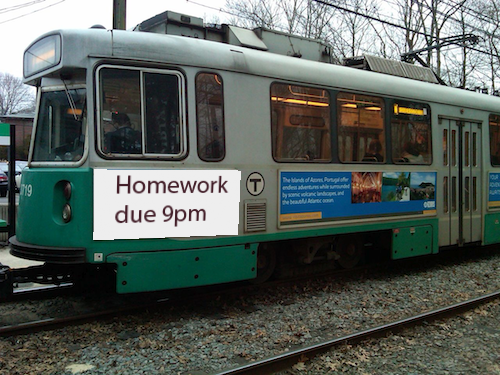

In [5]:
def apply_homography_bi(train_img, poster_img, H):
    output_img = train_img.copy()

    (height, width, channels) = output_img.shape
    (poster_h, poster_w, poster_c) = poster_img.shape

    for y in range(0, height):
        for x in range(0, width):
            (y_pos, x_pos) = calculate_coords(y, x, H)
            y1 = int(y_pos)
            y2 = y1+1
            x1 = int(x_pos)
            x2 = x1+1

            if  __between(y1, 0, poster_h) \
            and __between(x1, 0, poster_w) \
            and __between(y2, 0, poster_h) \
            and __between(x2, 0, poster_w):
                for i in range(0, channels):
                    output_img[y, x, i] = bilinear_interpolation(
                        y_pos,x_pos,
                        y1,y2,x1,x2,
                        poster_img[y1, x1, i],
                        poster_img[y1, x2, i],
                        poster_img[y2, x1, i],
                        poster_img[y2, x2, i]
                    )
    return output_img

output_img = apply_homography_bi(train_img, poster_img, H)
output_path = 'output/trainBI.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

As we can see at the output image, the border is quite ugly. Little fix for that:

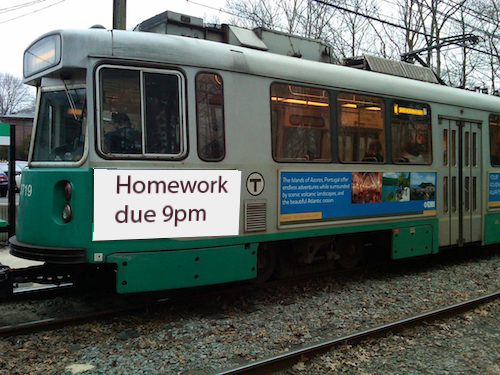

In [6]:
def apply_homography_bi2(train_img, poster_img, H):
    output_img = train_img.copy()

    (height, width, channels) = output_img.shape
    (poster_h, poster_w, poster_c) = poster_img.shape

    for y in range(0, height):
        for x in range(0, width):
            (y_pos, x_pos) = calculate_coords(y, x, H)
            y1 = int(y_pos)
            y2 = y1+1
            x1 = int(x_pos)
            x2 = x1+1

            by1 = __between(y1, 0, poster_h)
            bx1 = __between(x1, 0, poster_w)
            by2 = __between(y2, 0, poster_h)
            bx2 = __between(x2, 0, poster_w)
            if by1 or bx1 or by2 or bx2:
                for i in range(0, channels):
                    v11=v12=v21=v22 = output_img[y, x, i]
                    if by1 and bx1:
                        v11 = poster_img[y1, x1, i]
                    if by1 and bx2:
                        v12 = poster_img[y1, x2, i]
                    if by2 and bx1:
                        v21 = poster_img[y2, x1, i]
                    if by2 and bx2:
                        v22 = poster_img[y2, x2, i]

                    output_img[y, x, i] = bilinear_interpolation(
                        y_pos,x_pos,
                        y1,y2,x1,x2,
                        v11,v12,v21,v22
                    )
    return output_img

output_img = apply_homography_bi2(train_img, poster_img, H)
output_path = 'output/trainBI2.png'
cv2.imwrite(output_path,output_img)
Image(output_path)